0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly
from plotly import express as px
from matplotlib import gridspec
from IPython.display import Image

1. HELPER FUNCTIONS

2. LOADING DATA

In [2]:
#read files - sales and locations
df_sales = pd.read_csv('Kaggle-data/train.csv', low_memory=False) #low_memory false faz com que leia todo arquivo de uma vez
df_stores = pd.read_csv('Kaggle-data/store.csv', low_memory=False)

#merge datasets
df_raw = pd.merge(df_sales, df_stores, how ='left', on ='Store')

3. DATA DESCRIPTION

In [3]:
#copy dataset
df1 = df_raw.copy()

#rename columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#build function 
snakecase = lambda x: inflection.underscore(x)
#apply function in cols_old
cols_new = list(map(snakecase, cols_old))
#rename
df1.columns = cols_new

#data dimensions
li = df1.shape[0]
co = df1.shape[1]
print(f'The number of rows is {li}')
print(f'The number of columns is {co}')

#data types
df1.dtypes
df1['date'] = pd.to_datetime(df1['date'], format = '%Y-%m-%d')

#check na
df1.isna().sum()

The number of rows is 1017209
The number of columns is 18


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [4]:
#fillout na

#competition_distance
#it was considered that is it is na, it has no close competition. So distance was filled with a high value 
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#filled with sales month date - so it will be as the competition started in the same date as the sale
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)


#competition_open_since_year
#filled with sales date - so it will be as the competition started in the same date as the sale
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
#filled with sales date - so it will be as the promo2 started in the same date as the sale
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
#filled with sales date - so it will be as the promo2 started in the same date as the sale
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
df1['promo_interval'].fillna(0, inplace= True)

#promo now
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12: 'Dec'} 
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['promo_now'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [5]:
#change types
df1.dtypes

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)      
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [6]:
df2 = df1.copy()

In [7]:
#statistics

#numeric data
num_attributes = df2.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])


#central 
df_mean = pd.DataFrame(num_attributes.apply(np.mean))
df_median = pd.DataFrame(num_attributes.apply(np.median))


#dispersions
df_std = pd.DataFrame(num_attributes.apply(np.std))
df_max = pd.DataFrame(num_attributes.apply(max))
df_min = pd.DataFrame(num_attributes.apply(min))
df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

statistics = pd.concat([df_mean, df_median, df_min, df_max, df_range, df_std, df_skew, df_kurtosis], axis=1).reset_index()
statistics.columns = ['attributes','mean','median','minimum','maximum','range','std','skewness','kurtosis']



statistics

,attributes,mean,median,minimum,maximum,range,std,skewness,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='assortment', ylabel='sales'>

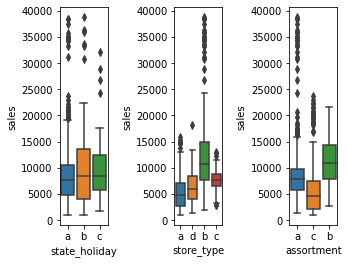

In [8]:
#categorical attributes

plt.rcParams['figure.dpi'] = 180 # default for me was 75

aux = df2[(df2['state_holiday'] !='0') & (df2['sales'] > 0)]
   
plt.subplot(1,6,1)
sns.boxplot(x ='state_holiday' , y= 'sales', data = aux)

plt.subplot(1,6,3)
sns.boxplot(x = 'store_type', y = 'sales', data = aux)

plt.subplot(1,6,5)
sns.boxplot(x = 'assortment', y = 'sales', data = aux)

#ponto mais baixo - minimo
#quartil 25 - 25% dos dados estão até este ponto
#quartil 50 - mediana - 50% dos dados estão até este ponto 
#quartil 75 - 75¨% dos dados estão até este ponto


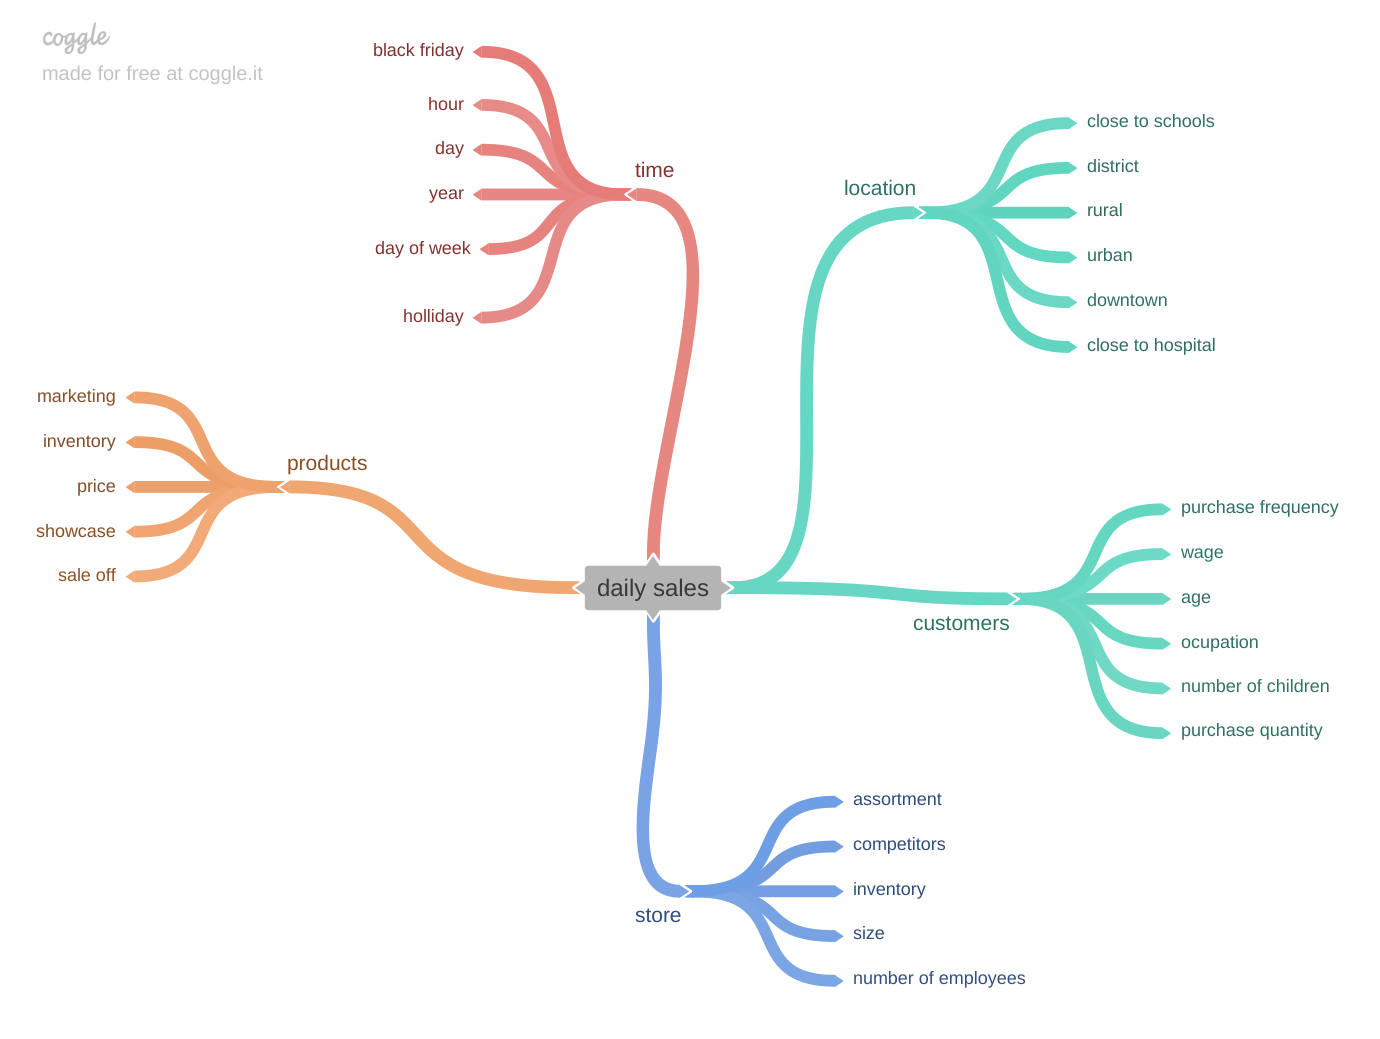

In [9]:
Image('img/mindmap2.png')

In [10]:
df3 = df2.copy()

In [11]:
#year
df3['year'] = df3['date'].dt.year

#month
df3['month'] = df3['date'].dt.month

#day
df3['day'] = df3['date'].dt.day

#week of year
df3['week_of_year'] = df3['date'].dt.isocalendar().week

#year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

#competition since
df3['competition_since'] = df3.apply(lambda x: str(x['competition_open_since_year']) + '-' + str(x['competition_open_since_month']) + '-' + '01', axis=1)
df3['competition_since'] = pd.to_datetime(df3['competition_since'], format = '%Y-%m-%d')
df3['competition_time_days'] = df3.apply(lambda x: x['date'] - x['competition_since'], axis=1)
#transform days into months
df3['competition_time_days'] = df3['competition_time_days'].astype('timedelta64[D]')
df3['competition_time_month'] = df3['competition_time_days']/30
df3['competition_time_month'] = round(df3['competition_time_month'],0)

#promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo_time_days'] = df3['date'] - df3['promo_since']
#transform days into weeks
df3['promo_time_days'] = df3['promo_time_days'].astype('timedelta64[D]')
df3['promo_time_weeks'] = df3['promo_time_days']/7
df3['promo_time_weeks'] = round(df3['promo_time_weeks'],0)


#assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x=='a' else
                                                       'extra' if x=='b' else
                                                        'extended')

#holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else
                                                            'easter_holiday' if x=='b' else
                                                            'christmas' if x=='c' else 
                                                            'regular_day' )


In [12]:
df3.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,...,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,...,0,0,0,0,0,0,0,0,0,0
customers,555,625,821,1498,559,589,1414,833,687,681,...,0,0,0,0,0,0,0,0,0,0
open,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
promo,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,...,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday
school_holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a,...,a,a,a,c,c,a,c,a,a,d
